In [4]:
# Let's make synthetic data to build our model on.
# We want to deconvolute mixtures of cell data. We'll start with 4 test cell types.
# We'll make 1000 reads per cell type.
# We'll make 100 CpGs per cell type.

import numpy as np
import pandas as pd

# Make 4 cell types
cell_types = ["A", "B", "C", "D"]

# Make 1000 reads per cell type
reads_per_cell_type = 1000

# Read size in bp
read_size_bp = 100

In [5]:
# Make a DataFrame with 4 cell types, 1000 reads per cell type
# We pass a sliding window of 100 BP to the model, and identify CpGs within that window
# We then assign a methylation status to each CpG
# Note we will have a data frame with 100 CpG columns, each with a value from -1-1 (where -1 is unable to be assigned)

data = []
for cell_type in cell_types:
    for read in range(reads_per_cell_type):
        # Insert 100 random CpGs into the read
        # We will assign a methylation status to each CpG
        data.append([cell_type, read, np.random.randint(0,100000), np.array([np.random.randint(-1, high=1) for i in range(read_size_bp)])])
            

data = pd.DataFrame(data, columns=["cell_type", "read", "pos", "methylation_status"])

# Convert the methylation status column into individual columns
data = pd.concat([data.drop("methylation_status", axis=1), data["methylation_status"].apply(pd.Series)], axis=1)

# Set column names to strings
data.columns = data.columns.astype(str)

# Drop the read column
data = data.drop("read", axis=1)

# Drop the pos column
data = data.drop("pos", axis=1)

data

,cell_type,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,A,0,-1,0,0,0,0,0,0,0,...,0,-1,-1,0,-1,0,0,-1,-1,0
1,A,0,-1,-1,-1,-1,-1,0,-1,0,...,-1,-1,0,0,-1,0,0,-1,-1,-1
2,A,-1,-1,-1,0,0,0,0,-1,-1,...,0,0,-1,0,0,-1,-1,0,0,-1
3,A,-1,-1,0,-1,-1,-1,0,-1,0,...,-1,-1,-1,0,0,-1,-1,0,0,0
4,A,-1,0,0,-1,0,-1,0,0,0,...,-1,-1,0,-1,-1,-1,0,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,D,-1,0,0,-1,-1,-1,-1,-1,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3996,D,-1,-1,-1,0,0,-1,-1,0,-1,...,-1,-1,-1,-1,-1,0,-1,0,-1,0
3997,D,0,0,0,0,0,-1,-1,-1,0,...,-1,-1,0,-1,-1,-1,0,-1,-1,0
3998,D,-1,0,0,0,-1,0,-1,-1,-1,...,0,-1,0,0,-1,-1,-1,-1,-1,0


In [54]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop("cell_type", axis=1), data["cell_type"], test_size=0.2, random_state=0)



In [55]:
# Fit a GradientBoostingClassifier to the training data
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

GradientBoostingClassifier()

In [56]:
# Predict cell lineage for the test data
y_pred = gbc.predict(X_test)

# Compute accuracy metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))
print("Precision: {}".format(precision_score(y_test, y_pred, average="weighted")))
print("Recall: {}".format(recall_score(y_test, y_pred, average="weighted")))
print("F1: {}".format(f1_score(y_test, y_pred, average="weighted")))

Accuracy: 0.2475
Precision: 0.25155834601785915
Recall: 0.2475
F1: 0.24784707574820924


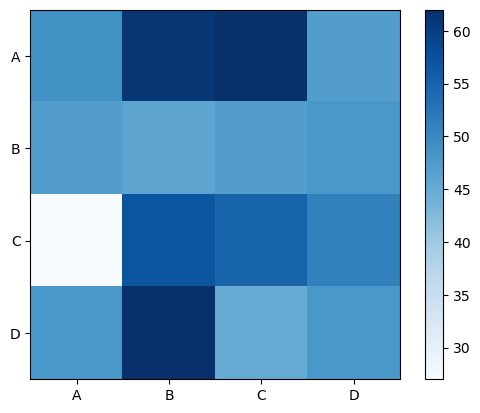

In [57]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
# Include the cell types as the tick marks
plt.xticks(np.arange(len(cell_types)), cell_types)
plt.yticks(np.arange(len(cell_types)), cell_types)
plt.colorbar()

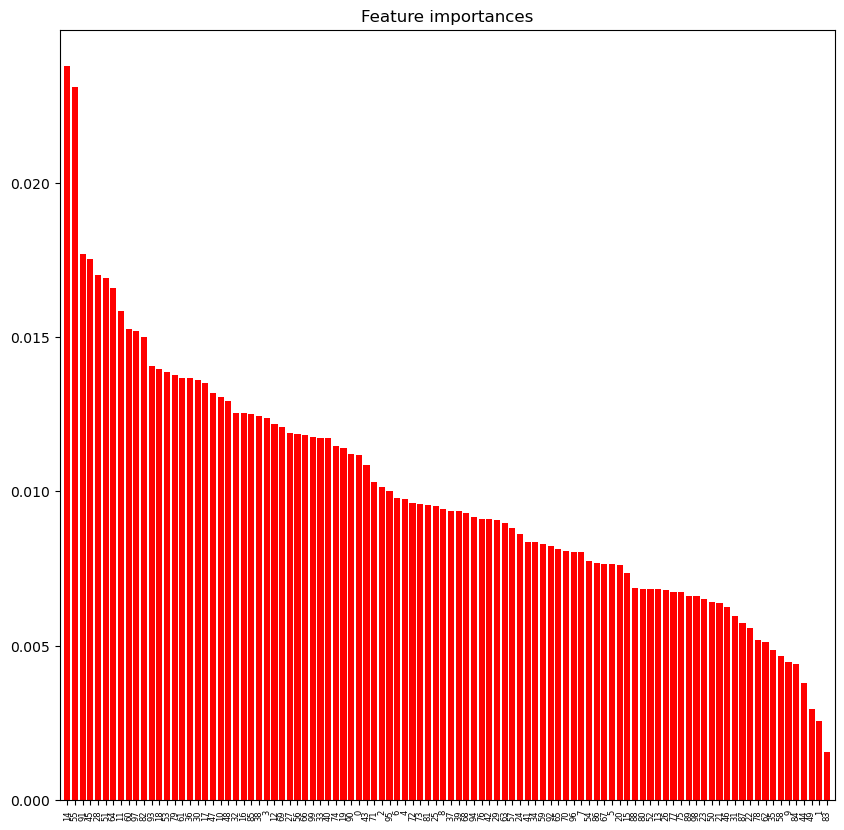

In [63]:
# Plot our model's feature importances
importances = gbc.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,10))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), indices, rotation=90, fontsize=6)
plt.xlim([-1, X_train.shape[1]])
plt.show()


In [10]:
import torch
from tab_transformer_pytorch import FTTransformer
from tab_transformer_pytorch import TabTransformer

# cont_mean_std = torch.randn(10, 2)

model = TabTransformer(
    categories = (3,),      # tuple containing the number of unique values within each category
    num_continuous = 100,   # number of continuous values
    dim = 32,               # dimension, paper set at 32
    dim_out = 4,            # binary prediction, but could be anything
    depth = 6,              # depth, paper recommended 6
    heads = 8,              # heads, paper recommends 8
    attn_dropout = 0.1,     # post-attention dropout
    ff_dropout = 0.1,        # feed forward dropout
    mlp_hidden_mults = (4, 2),          # relative multiples of each hidden dimension of the last mlp to logits
    mlp_act = nn.ReLU(),                # activation for final mlp, defaults to relu, but could be anything else (selu etc)
    # continuous_mean_std = cont_mean_std # (optional) - normalize the continuous values before layer norm
)



In [ ]:

# Let's try to build a model that can predict cell type from methylation status
# We'll use the FTTransformer model from the paper
# https://arxiv.org/pdf/2012.06678.pdf
#model = FTTransformer(
    categories = (3,),      # tuple containing the number of unique values within each category
    num_continuous = 100,   # number of continuous values
    dim = 32,               # dimension, paper set at 32
    dim_out = 4,            # binary prediction, but could be anything
    depth = 6,              # depth, paper recommended 6
    heads = 8,              # heads, paper recommends 8
    attn_dropout = 0.1,     # post-attention dropout
    ff_dropout = 0.1        # feed forward dropout
)


In [24]:

# Convert the cell type column to a numerical value
data["cell_type"] = data["cell_type"].astype("category").cat.codes

# Convert the DataFrame to a PyTorch tensor
data_tensor = torch.tensor(data.values)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_tensor[:, 1:], data_tensor[:, 0], test_size=0.2, random_state=0)

# FTTTransformer has no attribute fit
# We'll use the PyTorch optimizer to train the model
# https://pytorch.org/docs/stable/optim.html
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001)

# We'll use the PyTorch loss function to compute the loss
# https://pytorch.org/docs/stable/nn.html#loss-functions
import torch.nn as nn
criterion = nn.CrossEntropyLoss()

# Train the model
for epoch in range(10):
    # Forward pass
    # Model expects a tuple of model(x_categ, x_cont)
    # x_categ is a tensor of shape (batch_size, num_categories)
    # x_cont is a tensor of shape (batch_size, num_continuous)
    # y is a tensor of shape (batch_size, num_classes)
    y_pred = model(X_train, y_train)
    # Compute loss
    loss = criterion(y_pred, y_train)
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print("Epoch: {}, Loss: {}".format(epoch, loss.item()))


AssertionError: you must pass in 1 values for your categories input

In [17]:
x_categ = torch.randint(0, 5, (1, 5))     # category values, from 0 - max number of categories, in the order as passed into the constructor above
x_cont = torch.randn(1, 10)

In [22]:
y_train

tensor([1, 2, 1,  ..., 1, 2, 2])

In [ ]:


# Fit the model to the training data
model.fit(X_train, y_train)

# Predict cell lineage for the test data
y_pred = model.predict(X_test)

# Compute accuracy metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))
print("Precision: {}".format(precision_score(y_test, y_pred, average="weighted")))
print("Recall: {}".format(recall_score(y_test, y_pred, average="weighted")))
print("F1: {}".format(f1_score(y_test, y_pred, average="weighted")))
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
# Include the cell types as the tick marks
plt.xticks(np.arange(len(cell_types)), cell_types)
plt.yticks(np.arange(len(cell_types)), cell_types)
plt.colorbar()

# Plot our model's feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,10))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), indices, rotation=90, fontsize=6)
plt.xlim([-1, X_train.shape[1]])
plt.show()




In [ ]:


model = FTTransformer(
    categories = (10, 5, 6, 5, 8),      # tuple containing the number of unique values within each category
    num_continuous = 10,                # number of continuous values
    dim = 32,                           # dimension, paper set at 32
    dim_out = 1,                        # binary prediction, but could be anything
    depth = 6,                          # depth, paper recommended 6
    heads = 8,                          # heads, paper recommends 8
    attn_dropout = 0.1,                 # post-attention dropout
    ff_dropout = 0.1                    # feed forward dropout
)

x_categ = torch.randint(0, 5, (1, 5))     # category values, from 0 - max number of categories, in the order as passed into the constructor above
x_numer = torch.randn(1, 10)              # numerical value

pred = model(x_categ, x_numer) # (1, 1)

In [3]:
x_categ

tensor([[ 4, 14, 17, 23, 28]])

In [4]:
x_numer

tensor([[ 2.3198, -0.4949, -2.0240,  0.0676, -1.4135, -0.4613, -0.0314, -2.5742,
          0.0613,  0.8984]])